In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
clean_data = pd.read_pickle('data/clean_data.pickle')
clean_fare = pd.read_pickle('data/clean_fare.pickle')

# Basic Questions

## a. What is the distribution of number of passengers per trip?

In [3]:
# Count the number of observations that belong to each value of 
# passenger count. Storing as a dataframe for plotting.
def get_distribution(df, group):
    """Count the number of observations that belong to each value of 
    passenger count. Storing as a dataframe for plotting.
    
    Params: 
        #TODO
    Returns:
        #TODO
    """
    df = pd.DataFrame(df.groupby(group).count().iloc[:,0])
    df = df.rename(columns={df.columns[0]: "counts"}).reset_index()
    return df

passenger_dist = clean_data.groupby('passenger_count').count().iloc[:,0]
passenger_dist = pd.DataFrame(passenger_dist).rename(columns={"medallion": "counts"})
passenger_dist.reset_index(inplace=True)

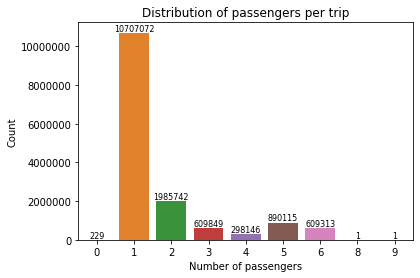

In [4]:
passenger_plot = sns.barplot(data=passenger_dist, x = "passenger_count", y="counts")
plt.title("Distribution of passengers per trip")
passenger_plot.set_xlabel("Number of passengers")
passenger_plot.set_ylabel("Count")
plt.ticklabel_format(style='plain', axis='y')
passenger_plot.bar_label(passenger_plot.containers[0], size=8, fmt="%d")
plt.show()

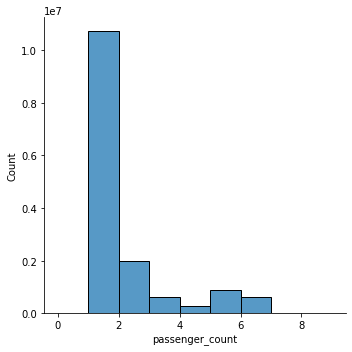

In [5]:
sns.displot(data = clean_data, x = "passenger_count", kind="hist", bins = [0,1,2,3,4,5,6,7,8,9])

**Summary**

## b. What is the distribution of payment_type?

In [6]:
payment_dist = clean_fare.groupby('payment_type').count().iloc[:,0]
payment_dist = pd.DataFrame(payment_dist).rename(columns={"medallion": "counts"})
payment_dist.reset_index(inplace=True)

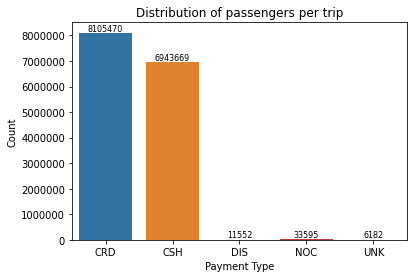

In [7]:
payment_plot = sns.barplot(data=payment_dist, 
                           x = "payment_type", 
                           y = "counts")
plt.title("Distribution of passengers per trip")
payment_plot.set_xlabel("Payment Type")
payment_plot.set_ylabel("Count")
plt.ticklabel_format(style='plain', 
                     axis='y')
payment_plot.bar_label(payment_plot.containers[0], 
                         size=8, 
                         fmt="%d")
plt.show()

**Summary**

Credit, Cash, Dispute, No charge, unkown

## c. What is the distribution of fare amount?

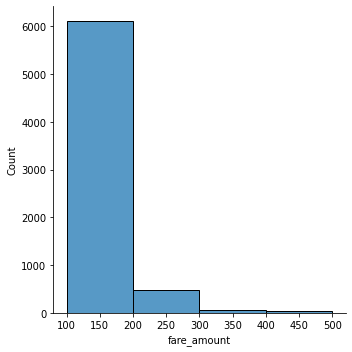

In [8]:
fare_plot = sns.displot(data=clean_fare,
                        x="fare_amount",
                        kind="hist",
                        bins=[100, 200, 300, 400, 500])
plt.ticklabel_format(style='plain', 
                     axis='y')

**Summary**

## d. What is the distribution of tip amount?

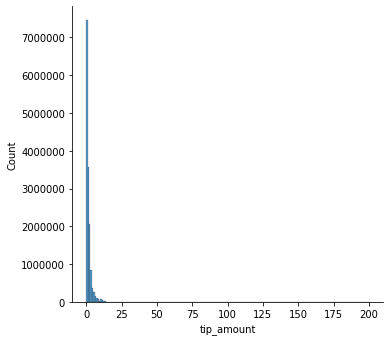

In [9]:
tip_plot = sns.displot(data=clean_fare,
                       x="tip_amount",
                       kind="hist",
                       binwidth=1)
plt.ticklabel_format(style='plain', 
                     axis='y')

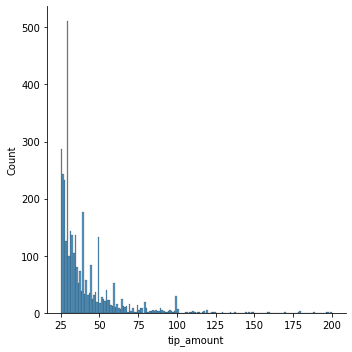

In [10]:
clean_tip_no_zero = clean_fare[clean_fare['tip_amount'] > 25]
sns.displot(data=clean_tip_no_zero,
                       x="tip_amount",
                       kind="hist",
                       binwidth=1)
plt.ticklabel_format(style='plain', 
                     axis='y')

**Summary**

Periodicity in the tip amount?

## e. What is the distribution of total amount?

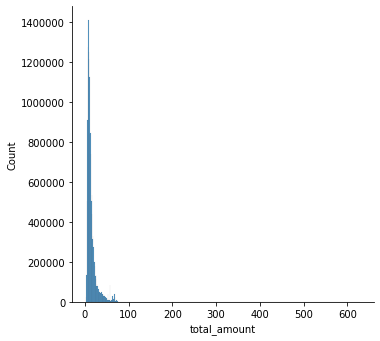

In [12]:
sns.displot(data=clean_fare,
                       x="total_amount",
                       kind="hist",
                       binwidth=1)
plt.ticklabel_format(style='plain', 
                     axis='y')

**Summary**

## f. What are top 5 busiest hours of the day?

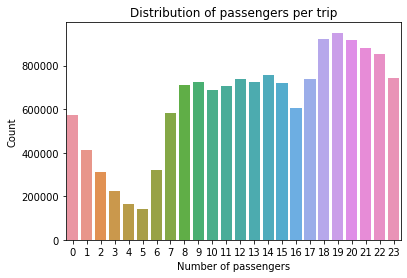

In [35]:
time_dist = get_distribution(clean_data, clean_data.pickup_datetime.dt.hour)
time_plot = sns.barplot(data=time_dist, x = "pickup_datetime", y="counts")
plt.title("Distribution of passengers per trip")
time_plot.set_xlabel("Number of passengers")
time_plot.set_ylabel("Count")
plt.ticklabel_format(style='plain', axis='y')
passenger_plot.bar_label(time_plot.containers[0], size=8, fmt="%d")
plt.show()

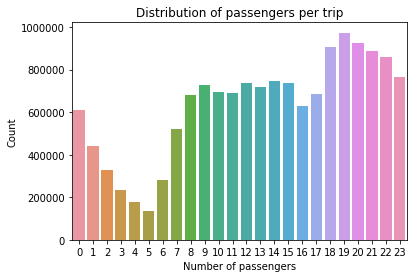

In [36]:
time_dist = get_distribution(clean_data, clean_data.dropoff_datetime.dt.hour)
time_plot = sns.barplot(data=time_dist, x = "dropoff_datetime", y="counts")
plt.title("Distribution of passengers per trip")
time_plot.set_xlabel("Number of passengers")
time_plot.set_ylabel("Count")
plt.ticklabel_format(style='plain', axis='y')
passenger_plot.bar_label(time_plot.containers[0], size=8, fmt="%d")
plt.show()